In [0]:
import pandas as pd
import numpy as np
import ast
import csv
import time

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [0]:
from graph_tool.all import *

ModuleNotFoundError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
users=np.zeros((40001,1))

In [0]:
users.shape

(40001, 1)

In [0]:
user_friends={}

In [0]:
max_friends=0
min_friends=200000

In [0]:
def hasMoreTags(s):
    return s[-1]!=']'

In [0]:
user_tags={}

# Generate User: Tags dict

In [0]:
start=time.time()
with open('/content/drive/My Drive/data.csv', 'r') as infile:
    reader = csv.reader(infile)
    count=-1
    
    for row in reader:
        #print(row[:7])
        count += 1
        if count == 0:
            continue
        id=row[0]
        #print(count)
        users[count-1][0]=id
        screenName=row[1]
        
        many_tags=hasMoreTags(row[2])
        
        offset=0
        #print('{} originally'.format(row[2]))
        #print(row[3])
        if many_tags:
            this_tags=[]
            for j in range(20):
                this_tags.append(row[2+j].strip('[]').strip(''))
                if row[2+j][-1]==']':
                    break
            #print('{} many tags'.format(this_tags))
            user_tags[id]=this_tags
            offset=len(this_tags)-1
            #print(offset)
        else:
            user_tags[id]=row[2].strip('[]').strip('')
            
        #followersCount=row[4]
        #print(offset)
        friendsCount=int(row[5+offset])
        #print(row[5+offset])
        max_friends=max(max_friends,friendsCount)
        min_friends=min(min_friends,friendsCount)
        friends=row[9+offset:]
        friends[0]=friends[0].strip('[]')
        friends[-1]=friends[-1].strip('[]')
        friends=[i.replace('"', '') for i in friends]
        friends=[i.strip() for i in friends]
        user_friends[id]=friends
        #print("{} : {}".format(count, friends))
end=time.time()
print('{} seconds'.format(end-start))

18.573724269866943 seconds


In [0]:
print(max_friends)
print(min_friends)

238749
101


In [0]:
# dict(list(user_friends.items())[0:2])

In [0]:
# dict(list(user_tags.items())[0:110])

# Generate/Read all tags

In [0]:
import re
def remove_hashtag(raw_str):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",raw_str).split())

In [0]:
try:
  all_tags=pd.read_csv('/content/drive/My Drive/all_tags_saved.csv')
except:
  all_tags=set()

  for u in user_tags:
    tags=user_tags[u]

    if type(tags) == str:
      all_tags.add(remove_hashtag(tags))
    else:
      for tag in tags:
        all_tags.add(remove_hashtag(tag))

  pd.DataFrame(list(all_tags)).to_csv('/content/drive/My Drive/all_tags_saved.csv')

In [0]:
len(all_tags)

128

# Generate Tag: User dict

In [0]:
tag_users={}

In [0]:
for u in user_tags:
  tags=user_tags[u]
  if type(tags)==str:
    normalized_tag=remove_hashtag(tags)
    if normalized_tag in tag_users:
      cur_tags=tag_users[normalized_tag]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
    else:
      cur_tags=[]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
  else:
    for tag in tags:
      normalized_tag=remove_hashtag(tag)
      if normalized_tag in tag_users:
        cur_tags=tag_users[normalized_tag]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags
      else:
        cur_tags=[]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags

In [0]:
len(tag_users)

128

In [0]:
x=list(tag_users.keys())

In [0]:
y=[len(item) for item in tag_users.values()]

In [0]:
tag_nums=pd.DataFrame({'tags':x,'num':y})

In [0]:
tag_nums

,tags,num
0,nationaldogday,30513
1,narcos,269
2,gloryoutnow,600
3,veranomtv2016,29
4,felipe massa,45
...,...,...
123,amatrice,2
124,yellen,2
125,pasalic,1
126,jorgesurprise,1


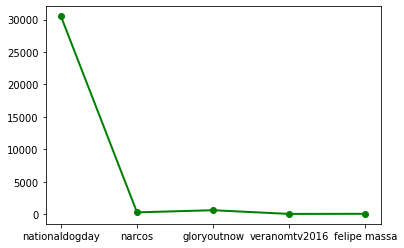

In [0]:
plt.plot(x[:5], y[:5],'go-', label='line 1', linewidth=2)

In [0]:
# Generate the nodes and edges
nodes=user_friends.keys()

In [0]:
len(nodes)

40000

In [0]:
#node_names=[]

In [0]:
# Generate the node names
#with open('/content/drive/My Drive/data.csv', 'r') as infile:
#    reader = csv.reader(infile)
#    count=-1
    
#    for row in reader:
#        count+=1
#        if count==0:
#            continue
#        node_names.append(row[1])

In [0]:
# node_names

In [0]:
#Generate the edges
#start=time.time()
#edges=[]

#for u in user_friends:
#    for v in user_friends[u]:
#        edges.append(tuple((u,v)))
#end=time.time()
#print('{} seconds'.format(end-start))

In [0]:
# edges

In [0]:
#len(edges)

# Build or read the graph

In [0]:
begin=time.time()
try:
  # nx.write_gpickle(G,"test.gpickle")
  # Read from pickle
  G=nx.read_gpickle("/content/drive/My Drive/test.gpickle")
  end=time.time()
  print('Spent {} in reading graph'.format(end-begin))
except:
  G=nx.Graph()
  G.add_edges_from(edges)
  end=time.time()
  print('{} seconds'.format(end-start))

Spent 119.39366245269775 in reading graph


In [0]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 12891798
Number of edges: 32842959
Average degree:   5.0952


# Calculate the shortest paths between two nodes

## Small Data Set (Sampled 5000 users)

In [0]:
users=user_friends.keys()
users=list(users)
sample_size=10

In [0]:
sampled_users=np.random.choice(users, sample_size)

In [0]:
# Get the minimum distances
has_no_paths=set() # a node may be unreachable to many other nodes
all_shortest_dis=[] # without nodes specified
all_shortest_dis_between_two_nodes={} # with nodes

In [0]:
print(sampled_users)

['493049694' '1211536693' '108493098' '444840138' '1970447983' '51887840'
 '22148421' '942876541' '263860625' '4908237917']


In [0]:
# General Distances
def calculate_distance(sampled_users,G,has_no_paths,all_shortest_dis_between_two_nodes,all_shortest_dis,sampled):
    count=0
    begin=time.time()
    size=len(sampled_users)
    if sampled:
      size=sampled_users.shape[0]

    for u in range(size):
        for v in range(u+1, size):
            count+=1
            if count%100==0:
              print('Calculated {} pairs'.format(count))

            node_u=sampled_users[u]
            node_v=sampled_users[v]
            
            try:
              cur_dis=nx.shortest_path_length(G,source=node_u,target=node_v)
              all_shortest_dis.append(cur_dis)
              all_shortest_dis_between_two_nodes[(node_u,node_v)]=cur_dis
            except:
              has_no_paths.add((node_u,node_v))

    end=time.time()
    print('Spent {} seconds, calculated {} pairs'.format(end-begin,count))

In [0]:
calculate_distance(sampled_users,G,has_no_paths,all_shortest_dis_between_two_nodes,all_shortest_dis,True)

Spent 0.21097397804260254 seconds, calculated 45 pairs


## Large Data Set (The Whole Data Set)

In [0]:
calculate_distance(users,G,has_no_paths,all_shortest_dis_between_two_nodes,all_shortest_dis,False)

Streaming output truncated to the last 5000 lines.
Calculated 399800 pairs
Calculated 399900 pairs
Calculated 400000 pairs
Calculated 400100 pairs
Calculated 400200 pairs
Calculated 400300 pairs
Calculated 400400 pairs
Calculated 400500 pairs
Calculated 400600 pairs
Calculated 400700 pairs
Calculated 400800 pairs
Calculated 400900 pairs
Calculated 401000 pairs
Calculated 401100 pairs
Calculated 401200 pairs
Calculated 401300 pairs
Calculated 401400 pairs
Calculated 401500 pairs
Calculated 401600 pairs
Calculated 401700 pairs
Calculated 401800 pairs
Calculated 401900 pairs
Calculated 402000 pairs
Calculated 402100 pairs
Calculated 402200 pairs
Calculated 402300 pairs
Calculated 402400 pairs
Calculated 402500 pairs
Calculated 402600 pairs
Calculated 402700 pairs
Calculated 402800 pairs
Calculated 402900 pairs
Calculated 403000 pairs
Calculated 403100 pairs
Calculated 403200 pairs
Calculated 403300 pairs
Calculated 403400 pairs
Calculated 403500 pairs
Calculated 403600 pairs
Calculated 40

# Calculate the shortest paths in the same tag

In [0]:
tag='nationaldogday'
users=tag_users[tag]
user_count=len(users)
print(user_count)

30513


In [0]:
unreachable=set()

In [0]:
for u in range(user_count):
  for v in range(u+1,user_count):
    cur_dis=-1
    node_u=users[u]
    node_v=users[v]

    if (node_u,node_v) in all_shortest_dis_between_two_nodes:
      cur_dis=all_shortest_dis_between_two_nodes[(node_u,node_v)]
    elif (node_v,node_u) in all_shortest_dis_between_two_nodes:
      cur_dis=all_shortest_dis_between_two_nodes[(node_v,node_u)]
    else:
      unreachable.add((node_u,node_v))

KeyboardInterrupt: ignored